[Last time](https://github.com/opetrova/TweakingInception/blob/master/GettingStarted.ipynb) we went over loading the pre-trained [Inception5h model](https://arxiv.org/abs/1409.4842) and running it on our own input images in excrutiating level of detail. This time we focus on **visualizing** the features that the different channels of various layers have been trained to detect. If you are already comfortable with tensorflow and neural networks, [DeepDreaming with TensorFlow](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb) is a great read, otherwise, here is a less technical version of that tutorial with a couple of lengthy detours. Lets go ahead and load the model:

In [1]:
import tensorflow as tf
import numpy as np

#from __future__ import print_function
#from io import BytesIO
import PIL.Image
from IPython.display import clear_output, Image, display

model_fn = 'tensorflow_inception_graph.pb'
mygraph = tf.Graph() 
sess = tf.InteractiveSession(graph=mygraph)

with tf.gfile.FastGFile(model_fn, 'rb') as f: 
    graph_def = tf.GraphDef() 
    graph_def.ParseFromString(f.read())  
    
t_input = tf.placeholder(np.float32, name='input') 
tf.import_graph_def(graph_def, {'input':t_input})

layers = [op.name for op in mygraph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
print('Number of Conv2D layers: ', len(layers))

C:\Users\Olga\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Number of Conv2D layers:  59


Andrew Ng has an excellent course on [Convolutional Neural Networks](https://www.coursera.org/learn/convolutional-neural-networks) on Coursera. If you just want to know what convolutional layers are, the [second video of the course](https://www.coursera.org/lecture/convolutional-neural-networks/edge-detection-example-4Trod) goes through an example of a convolution operation starting around 01:20. Basically, you can think of covering a part of your input image with a *filter*, the result of that being your output (both your input image and the filter are nothing but numbers, you just have to multiply one by the other in a particular way to get the "output" number), then sliding the filter to a different part of the image. Repeat until you've dragged the filter all over the - say, two-dimensional - input, and produced the two-dimensional output. 
Naturally, the filter should be smaller than your input image - it could be 3x3, 5x5, etc. The thing about filters is that different filters detect different things. These things could be a vertical edge in the input, a horizontal line, a wavy squiggle at 45 degrees, etc. Roughly speaking, if the input contains what the filter is looking for, the output is maximized. As a soon-to-be-former-physicist, I like convolutional NNs because they make use of the [translational invariance](https://en.wikipedia.org/wiki/Translational_symmetry) property: if you are interested in whether the input image contains a cat, you don't care *where* the cat is located on the image. That's why filters that *slide* over the entire image come in handy!

Continuing [my hand-waving guide to deep learning](https://www.olgapaints.net/blog/2018/7/27/inception-getting-started), lets see what the computer is actually learning in this scenario. When you start showing it images, at first the computer has no idea what kind of features to look for, so initially the filters are just matrices populated with random numbers (this should start to sound familiar). In an image classification problem, the network classifies each image *(input)* as belonging to a particular category *(output)*. While training, the computer compares its output to the correct answers, and adjusts the *trainable variables* **W** to get its output(s) closer to those correct values.

In convolutional layers, **W** are the filters: for a 3x3 filter, there is a total of nine values the computer will learn and later will use to classify the new input images it has not seen before. In a given layer, there are often multiple filters of the same size that are detecting different features (e.g., one for vertical and one for horizontal lines, etc). Lets see what kind of convolutional layers is the Inception network made up of:

In [2]:
import re 

for i in range(len(layers)):
    layers[i] = re.search('import/(.+?)/conv',layers[i]).group(1)
    
print(layers)

['conv2d0_pre_relu', 'conv2d1_pre_relu', 'conv2d2_pre_relu', 'mixed3a_1x1_pre_relu', 'mixed3a_3x3_bottleneck_pre_relu', 'mixed3a_3x3_pre_relu', 'mixed3a_5x5_bottleneck_pre_relu', 'mixed3a_5x5_pre_relu', 'mixed3a_pool_reduce_pre_relu', 'mixed3b_1x1_pre_relu', 'mixed3b_3x3_bottleneck_pre_relu', 'mixed3b_3x3_pre_relu', 'mixed3b_5x5_bottleneck_pre_relu', 'mixed3b_5x5_pre_relu', 'mixed3b_pool_reduce_pre_relu', 'mixed4a_1x1_pre_relu', 'mixed4a_3x3_bottleneck_pre_relu', 'mixed4a_3x3_pre_relu', 'mixed4a_5x5_bottleneck_pre_relu', 'mixed4a_5x5_pre_relu', 'mixed4a_pool_reduce_pre_relu', 'mixed4b_1x1_pre_relu', 'mixed4b_3x3_bottleneck_pre_relu', 'mixed4b_3x3_pre_relu', 'mixed4b_5x5_bottleneck_pre_relu', 'mixed4b_5x5_pre_relu', 'mixed4b_pool_reduce_pre_relu', 'mixed4c_1x1_pre_relu', 'mixed4c_3x3_bottleneck_pre_relu', 'mixed4c_3x3_pre_relu', 'mixed4c_5x5_bottleneck_pre_relu', 'mixed4c_5x5_pre_relu', 'mixed4c_pool_reduce_pre_relu', 'mixed4d_1x1_pre_relu', 'mixed4d_3x3_bottleneck_pre_relu', 'mixed4d_3

Lets look at the first layer and check what are the filter dimensions and how many filters are there. For the latter, we look at the last number in the shape of the tensor, corresponding to the output of the first layer:

In [3]:
print(mygraph.get_tensor_by_name('import/conv2d0_pre_relu:0').get_shape())

(?, ?, ?, 64)


The first three positions in the tensor's shape are question marks because in tensorflow, tensors are *symbolic* and only obtain numerical values when evaluated inside a tensorflow session. The first three values will depend on what is fed into the network: the batch size (number of images), then we have two dimensions for the ouput of each filter, and finally the number of filters in this layer, 64, which has no dependence on the input.

Now we know there are 64 filters in the layer called *conv2d0_pre_relu*; what about the size of the filters? We can look at the size of the weight matrix for this layer. To get weights and biases from a pre-trained network that we read from a *.pb* file, we look at the *constant* nodes of the graph:

In [4]:
weight_nodes = [n for n in graph_def.node if n.op=="Const"]
weight_names = [n.name for n in weight_nodes]
print(weight_names[0:10])
weights = dict(zip(weight_names, weight_nodes))

['conv2d0_w', 'conv2d0_b', 'conv2d1_w', 'conv2d1_b', 'conv2d2_w', 'conv2d2_b', 'mixed3a_1x1_w', 'mixed3a_1x1_b', 'mixed3a_3x3_bottleneck_w', 'mixed3a_3x3_bottleneck_b']


The nodes called *conv2d0_w* and *conv2d0_b* contain the pre-trained weights and biases, respectively, for the first (zeroth, if we want to use the same naming convention) layer. These are NodeDef objects that contain various information, but lets just check the size of the filters for the first few convolutional layers:

In [5]:
def get_weight_size(layer) :
    return [d.size for d in weights[layer].attr['value'].tensor.tensor_shape.dim]
print(get_weight_size('conv2d0_w'))
print(get_weight_size('conv2d1_w'))
print(get_weight_size('conv2d2_w'))

[7, 7, 3, 64]
[1, 1, 64, 64]
[3, 3, 64, 192]


Evidently, the filter size of the first convolutional layer is *7x7x3*. 3 comes from there being three channels for RGB (colored) images, and 64, as we already established, is the total number of filters (which becomes the number of channels for the next layer, hence the 64 in *1x1x64*, etc).

Inception 5h seems to be a realization of the so-called **GoogLeNet** network, whose architecture you can see in Fig. 3 of the [Going deeper with convolutions](https://arxiv.org/abs/1409.4842) paper. Starting with layer 3, multiple filter sizes are used at the same layer, hence the *mixed* in the layer names: *mixed3a_1x1_pre_relu*, *mixed3a_3x3_pre_relu*, *mixed3a_5x5_pre_relu* etc. This allows the Inception model to detect features at different lengthscales. Speaking of features, it is time to look at some of those!

# Visualizing layers of the Inception model

In the [previous tutorial](https://github.com/opetrova/TweakingInception/blob/master/GettingStarted.ipynb) we talked about how the computer learns the appropriate values of **W** (trainable parameters - weights and biases) during training. When using a pre-trained model, you already have values for **W**, but there is something else that we can learn. As I explained last time, when training a neural network, we feed input **X** into the first layer, where it gets multiplied by the weights **W1** to produce output **Z1**. **Z1** (or, when using an activation function such as [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks), **A1 = ReLU(Z1)**), then serves as input for the second layer, and this just goes on until we get the final output **Z**. We compute the appropriate weights **Wi** from minimizing the difference between **Z** and the correct output **Y**.

Lets say the training has finished, and **Wi** are fixed. In CNNs, each channel of each convolutional layer is associated with a particular filter, trained to detect a particular feature / set of features. To vizualize the features detected by a chosen channel, we can see what kind of input is needed to maximize the output of that channel. Mathematically, this problem is very similar to the one we were solving during training of the CNN, except that instead of minimizing the difference between **Z** and **Y**, we are now maximizing some output **Zi** for the *i*th layer, and the variables that we are solving for are **X** instead of **W**.

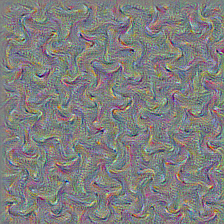

In [6]:
def display_output(a, screen=True, name=None, save=False) :
    # Using the raw output of a layer for visualization purposes doesn't work very well, 
    # so we normalize it to get the right range of values 
    # Here I use the constants from the 'DeepDreaming with TensorFlow' tutorial
    a = (a-a.mean())/max(a.std(), 1e-4)*0.1 + 0.5
    a = np.uint8(np.clip(a, 0, 1)*255)
    img = PIL.Image.fromarray(a)
    
    # display image on the screen
    if screen == True:
        display(img)
    
    # save the rendered image to a file
    if save == True and name != None:
        img.save("%s.jpg"%name)

''' Arguments:
    layer: name of the layer
    channel: number of the channel whose output is to be maximized
    img0: the initial input image, that will be modified to max the channel's output
    save_file = True if the final image is to be saved as a jpeg file
    iter_n, step: parameters for the gradient descent
'''
def render_channel(layer, channel, img0, save_file=False, iter_n=30, step=1.0) :
    # output of the channel : 
    t_output = mygraph.get_tensor_by_name("import/%s:0"%layer)[:,:,:,channel]
    # mean value of the output (this is what we want to be maximized) :
    t_mean = tf.reduce_mean(t_output) 
    # get the derivative of the [mean] output with respect to the input
    t_grad = tf.gradients(t_mean, t_input)[0] 
    
    img = img0.copy()
    for i in range(iter_n):
        g = sess.run(t_grad, {t_input:np.array(img)[np.newaxis,:]})
        g /= g.std()+1e-8  
        # update the input image (delta = gradient * step)
        img += g[0,:]*step
        
    display_output(img, name="%s_%s"%(layer, channel), save=save_file)

''' Visualize all the channels present in the layer. Try 'mixed4b_1x1_pre_relu'
if you are on the market for pretty, yet understated psychedelic wallpaper! '''    
def visualize_layer(layer) :  
    # number of channels in the layer :
    channels = int(mygraph.get_tensor_by_name("import/%s:0"%layer).get_shape()[-1])
    
    for c in range(channels):
        img_noise = np.random.uniform(size=(224,224,3)) + 100.0
        print('Layer ',layer,' channel ', c)
        render_channel(layer, c, img_noise)

# Let's visualize channel 97 of layer mixed4a_1x1_pre_relu :        
img = np.random.uniform(size=(224,224,3)) + 100.0
render_channel('mixed4a_1x1_pre_relu',97,img)    

As the table below demonstrates, the closer the layer is to the input, the more microscopic are the attributes it had been trained to detect, and on the contrary, the deeper the layer - the more abstract the features. First we detect, basically, things like edges, then edges start to form patterns, patterns eventually form objects, etc. One can imagine filters trained to detect eyes (*mixed4c_pool_reduce_pre_relu* channel 0), building parts (*mixed4c_pool_reduce_pre_relu* channel 61), and flowers (*mixed4d_3x3_bottleneck_pre_relu* channel 139). You should, however, keep in mind that many of these are going to be merely our brains' attempts to interpret what we are seeing as something that makes sense to us. For instance, as much as the output of *mixed4b_pool_reduce_pre_relu* channel 45 may resemble creepy human faces, the classification categories that GoogLeNet was trained to detect do not, in fact, include people.


| ![eyes](conv2d1_pre_relu_52.jpg) | ![houses](conv2d2_pre_relu_8.jpg) | ![flowers](conv2d2_pre_relu_27.jpg) |
| --- | --- | --- |
| *conv2d1_pre_relu* ch 52 | *conv2d2_pre_relu* ch 8 | *conv2d2_pre_relu* ch 27 |

| ![eyes](mixed3b_1x1_pre_relu_47.jpg) | ![houses](mixed3b_3x3_pre_relu_66.jpg) | ![flowers](mixed3b_pool_reduce_pre_relu_26.jpg) |
| --- | --- | --- |
| *mixed3b_1x1_pre_relu* ch 47 | *mixed3b_3x3_pre_relu* ch 66 | *mixed3b_pool_reduce_pre_relu* ch 26 |

| ![eyes](mixed4a_1x1_pre_relu_5.jpg) | ![houses](mixed4a_3x3_pre_relu_111.jpg) | ![flowers](mixed4b_pool_reduce_pre_relu_45.png) |
| --- | --- | --- |
| *mixed4a_1x1_pre_relu* ch 5 | *mixed4a_3x3_pre_relu* ch 111 | *mixed4b_pool_reduce_pre_relu* ch 45 |

| ![eyes](L32c0.png) | ![houses](L32c61.png) | ![flowers](L34c139.png) |
| --- | --- | --- |
| *mixed4c_pool_reduce_pre_relu* ch 0 | *mixed4c_pool_reduce_pre_relu* ch 61 | *mixed4d_3x3_bottleneck_pre_relu* ch 139 |

Another thing that is evident is that features keep getting repeated on our derived "input" images. This makes sense given the nature of the convolutional layers: namely, the way that the filter slides over the image. 

In [7]:
sess.close()